In [1]:
import scipy.io as sio 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.lines as mlines
from reinforcement_learning_mp import offpolicy_eval_tdlearning_with_morta_mp
from utils import smooth 
from sklearn.cluster import KMeans
import pickle 
from multiprocessing import freeze_support 

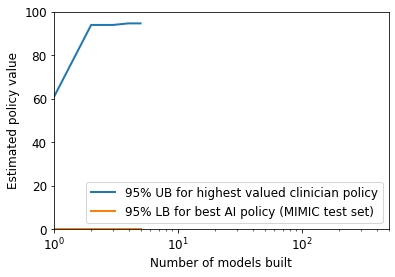

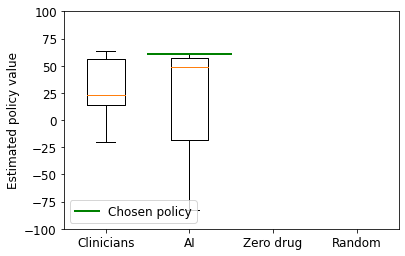

####   MODEL CALIBRATION - CLINICIANS POLICY EVALUATION WITH TD LEARNING   ####


C:\Users\sayan\AppData\Local\Temp/ipykernel_30648/4250601006.py:105: RuntimeWarning: Mean of empty slice
  h[i,0]=np.nanmean(m[ii])  # mean mortality in this bin
c:\Users\sayan\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\sayan\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
c:\Users\sayan\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
d:\MIMIC\py_ai_clinician\utils.py:74: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the futur

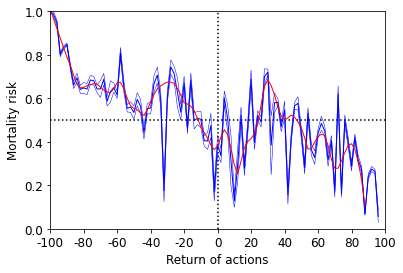

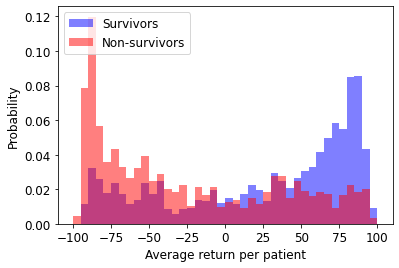

In [2]:
if __name__ == '__main__': 
    
    freeze_support()

    # Loading start file 

    with open('bestpol.pkl', 'rb') as file:
        modl = pickle.load(file)
        Qon = pickle.load(file)
        physpol = pickle.load(file)
        transitionr = pickle.load(file) 
        transitionr2 = pickle.load(file)
        R = pickle.load(file)
        C = pickle.load(file)
        train = pickle.load(file)
        qldata3train = pickle.load(file)
        qldata3test = pickle.load(file)

    with open('step_5_start.pkl','rb') as file: 
        MIMICzs = pickle.load(file)
        actionbloc = pickle.load(file)
        reformat5 = pickle.load(file)
        recqvi = pickle.load(file) 

    idx=C.predict(MIMICzs[train,:])  #N-D nearest point search: look for points closest to each centroid
    actionbloctrain=actionbloc[train==True]
    outcome = 9 #   HOSPITAL MORTALITY = 8 / 90d MORTA = 10
    Y90=reformat5[train==True,outcome]
    ptid=reformat5[train==True,1] 
    
    ## FIB 2A plot safety of algos: 95th UB of physicians policy value vs 95th LB of AI policy
    # during bulding of 500 different models
    # show that the value of AI policy is always guaranteed to be better than doctors' according to the model

    plt.rcParams.update({'font.size': 12})
    fig, ax = plt.subplots()
    plt.ylim(0,100)
    plt.xlim(1,500)

    r = recqvi 
    # print(r.shape[0])
    x = np.zeros((r.shape[0],1))
    m = np.zeros((r.shape[0],1)) 
    for i in range(r.shape[0]): 
        x[i] = i+1 # start from one 
        if(r[i,18]>max(m)): # physicians    // OR 19 = 95th percentile!!!!!!!!!!!!
            m[i]=r[i,18] 
        else: 
            m[i]=max(m) 


    ax.semilogx(x,m,linewidth=2)


    x = np.zeros((r.shape[0],1))    
    m = np.zeros((r.shape[0],1)) 

    for i in range(r.shape[0]): 
        x[i] = i+1 # start from one 
        if(r[i,23]>max(m)): # learnt policy
            m[i]=r[i,23] 
        else: 
            m[i]=max(m) 
    ax.semilogx(x,m,linewidth=2)

    ax.set_xlabel('Number of models built')
    ax.set_ylabel('Estimated policy value')
    ax.legend(['95% UB for highest valued clinician policy','95% LB for best AI policy (MIMIC test set)'],loc='lower right')
    plt.show() 

    # eICU part was not included 
    
    ## FIG 2B BOXPLOT OF POLICY VALUE OVER 500 MODELS -  MIMIC TEST SET ONLY

    plt.rcParams.update({'font.size': 12})
    fig, ax = plt.subplots()
    ax.boxplot(recqvi[:,[19, 21, 24, 25]],labels=['Clinicians','AI','Zero drug','Random']) # some evaluations not done here
    plt.xlim(0.5,4.5)
    plt.ylim(-100,100)
    ax.set_ylabel('Estimated policy value')

    # print([max(recqvi[:,21]),max(recqvi[:,21])])

    line = mlines.Line2D([1.5,2.5],[max(recqvi[:,21]),max(recqvi[:,21])],linewidth=2,color='green')
    ax.add_line(line)
    ax.legend([line],['Chosen policy'],loc='lower left')
    plt.show() 

    ## FIG 2C = MODEL CALIBRATION

    # TD learning of physicians / bootstrapped, in MIMIC train set.
    # This version also records action return and mortality, for the plot (nb: no parfor here)

    print('####   MODEL CALIBRATION - CLINICIANS POLICY EVALUATION WITH TD LEARNING   ####')
    bootql,prog=offpolicy_eval_tdlearning_with_morta_mp( qldata3train, physpol, ptid,  idx, actionbloctrain, Y90, 0.99, 100 ) # 100 reps

    nbins=100
    a=prog[:,0] #Q values of actual actions
    qv=np.floor((a+100)/(200/nbins))  # converts Q values to integers btw 0 and nbins
    m=prog[:,1]  #outcome
    h=np.zeros((nbins,5))  #avg mortality and other results, per bin

    for i in range(nbins):     
        ii=(qv==i) 
        h[i,0]=np.nanmean(m[ii])  # mean mortality in this bin
        if m[ii].size>0: 
            h[i,4]=np.nanmean(a[ii]) #record the mean of Q values in the bin (to make sure it matches what I expect)
        h[i,1]=np.std(m[ii])/np.sqrt(m[ii].size) # SEM of mortality in this bin
        h[i,2]=m[ii].size # nb of data points in this bin

    h[:,3]=h[:,0]*h[:,2]/qv.size # weighted average!!
    # [nansum(h(:,4)) mean(prog(:,2))] %check that both are close!

    yy1=smooth(np.array(range(nbins)),h[:,0],0.1)


    fig, ax = plt.subplots()
    plt.xlim(0,nbins)
    plt.ylim(0,1)
    plt.plot([0,nbins],[0.5,0.5],linestyle=':',color='black')
    plt.plot([nbins/2,nbins/2],[0,1],linestyle=':',color='black')
    plt.plot(h[:,0],linewidth=1,color='blue')
    plt.plot(h[:,0]+h[:,1],linewidth=0.5,color='blue')
    plt.plot(h[:,0]-h[:,1],linewidth=0.5,color='blue')
    plt.plot(yy1,linewidth=1,color='red')
    ax.set_ylabel('Mortality risk')
    ax.set_xlabel('Return of actions')
    plt.xticks(np.arange(0,nbins+10,step = nbins/10), np.arange(-100,120,step=20))
    plt.show() 
    
    ## FIG 2D = Computes avg Q value per patient / MIMIC TRAIN SET
    fig, ax = plt.subplots()
    df = pd.DataFrame(prog,columns = ['Qoff','morta','id','rep'])
    d = df.groupby(['rep','id']).mean()
    edges = np.arange(-100,105,5)
    data = np.array(d[d['morta']==0]['Qoff'])
    plt.hist(data,edges,facecolor='b',weights=np.ones(len(data)) / len(data), alpha=0.5)
    data = np.array(d[d['morta']==1]['Qoff'])
    plt.hist(data,edges,facecolor='r',weights=np.ones(len(data)) / len(data), alpha=0.5)
    ax.legend(['Survivors','Non-survivors'],loc='upper left')
    ax.set_xlabel('Average return per patient')
    ax.set_ylabel('Probability')
    plt.show()